In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model # type: ignore
import json
import shutil

In [3]:
def generate_signals(y_prob, threshold=0.55):
    """
    Convert predicted probabilities into trading signals.
    1 = Buy, 0 = Flat/Hold
    """
    return (y_prob > threshold).astype(int)

def backtest(prices, signals, fee=0.001, slippage=0.0005, 
             stop_loss=None, take_profit=None, initial_capital=1000):
    """
    Simple backtest engine with risk controls.
    Args:
        prices: array of close prices
        signals: array of {0,1} buy/hold signals
        fee: trading commission per trade
        slippage: price slippage fraction
        stop_loss: stop-loss threshold (fraction, e.g. 0.05 = 5%)
        take_profit: take-profit threshold (fraction)
        initial_capital: starting USD
    Returns:
        results dict with equity curve and metrics
    """
    capital = initial_capital
    position = 0
    entry_price = None
    equity_curve = []

    for i in range(len(signals)-1):
        price_today = prices[i]
        price_next = prices[i+1]

        # Enter trade
        if signals[i] == 1 and position == 0:
            btc_bought = capital / (price_today * (1 + fee + slippage))
            position = btc_bought
            capital = 0
            entry_price = price_today

        # Exit trade by signal
        elif signals[i] == 0 and position > 0:
            capital = position * price_today * (1 - fee - slippage)
            position = 0
            entry_price = None

        # Risk controls
        if position > 0 and entry_price:
            drawdown = (price_today - entry_price) / entry_price
            if stop_loss and drawdown <= -stop_loss:
                capital = position * price_today * (1 - fee - slippage)
                position = 0
                entry_price = None
            elif take_profit and drawdown >= take_profit:
                capital = position * price_today * (1 - fee - slippage)
                position = 0
                entry_price = None

        equity = capital + position * price_today
        equity_curve.append(equity)

    equity_curve = np.array(equity_curve)

    # Metrics
    returns = np.diff(equity_curve) / equity_curve[:-1]
    cum_return = equity_curve[-1] / initial_capital - 1
    sharpe = (np.mean(returns) / (np.std(returns) + 1e-9)) * np.sqrt(252) if len(returns) > 1 else 0
    max_dd = np.max(np.maximum.accumulate(equity_curve) - equity_curve)
    max_dd_pct = max_dd / np.max(np.maximum.accumulate(equity_curve))

    return {
        "final_equity": equity_curve[-1],
        "cumulative_return": cum_return,
        "sharpe_ratio": sharpe,
        "max_drawdown": max_dd,
        "max_drawdown_pct": max_dd_pct,
        "equity_curve": equity_curve
    }

In [37]:
def plot_equity_curve(equity_curve, output_dir):
    plt.figure(figsize=(10,5))
    plt.plot(equity_curve, label="Equity Curve")
    plt.title("Equity Curve")
    plt.xlabel("Days")
    plt.ylabel("Equity ($)")
    plt.legend()
    file_path = os.path.join(output_dir, "equity_curve.png")
    plt.savefig(file_path, dpi=150, bbox_inches="tight")
    plt.close()
    return file_path

def plot_returns_histogram(equity_curve, output_dir):
    returns = np.diff(equity_curve) / equity_curve[:-1]
    plt.figure(figsize=(7,5))
    plt.hist(returns, bins=30, alpha=0.7, color="steelblue")
    plt.title("Distribution of Daily Returns")
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")
    file_path = os.path.join(output_dir, "returns_hist.png")
    plt.savefig(file_path, dpi=150, bbox_inches="tight")
    plt.close()
    return file_path

def generate_html_report(results, equity_path, hist_path, output_dir, config):
    html_file = os.path.join(output_dir, "backtest_report.html")
    with open(html_file, "w") as f:
        f.write("<html><head><title>Backtest Report</title></head><body>")
        f.write("<h1>Backtest Performance Report</h1>")
        
        # Config
        f.write("<h2>Config</h2><ul>")
        for k,v in config.items():
            f.write(f"<li>{k}: {v}</li>")
        f.write("</ul>")
        
        # KPIs
        f.write("<h2>Key Metrics</h2><ul>")
        f.write(f"<li>Final Equity: ${results['final_equity']:.2f}</li>")
        f.write(f"<li>Cumulative Return: {results['cumulative_return']*100:.2f}%</li>")
        f.write(f"<li>Sharpe Ratio: {results['sharpe_ratio']:.2f}</li>")
        f.write(f"<li>Max Drawdown: {results['max_drawdown_pct']*100:.2f}%</li>")
        f.write("</ul>")
        
        # Charts
        f.write("<h2>Charts</h2>")
        f.write(f'<img src="{os.path.basename(equity_path)}" width="600"><br>')
        f.write(f'<img src="{os.path.basename(hist_path)}" width="600"><br>')
        
        f.write("</body></html>")
    return html_file

def save_json_report(results, config, output_dir):
    json_file = os.path.join(output_dir, "backtest_report.json")
    json_data = {
        "final_equity": float(results["final_equity"]),
        "cumulative_return": float(results["cumulative_return"]*100),
        "sharpe": float(results["sharpe_ratio"]),
        "max_drawdown": float(results["max_drawdown"]),
        "max_drawdown_pct": float(results["max_drawdown_pct"]*100),
        "config": config
    }
    with open(json_file, "w") as f:
        json.dump(json_data, f, indent=4)
    return json_file

def backtest_with_report(prices, y_prob, threshold=0.55, 
                         stop_loss=None, take_profit=None, 
                         output_dir="backtest_results"):
    os.makedirs(output_dir, exist_ok=True)

    signals = generate_signals(y_prob, threshold=threshold)
    results = backtest(prices, signals, stop_loss=stop_loss, take_profit=take_profit)

    equity_path = plot_equity_curve(results["equity_curve"], output_dir)
    hist_path = plot_returns_histogram(results["equity_curve"], output_dir)

    config = {"threshold": threshold, "stop_loss": stop_loss, "take_profit": take_profit}
    report_file = generate_html_report(results, equity_path, hist_path, output_dir, config)

    json_file = save_json_report(results, config, output_dir)

    print(f"Backtest report saved to {report_file}")
    print(f"JSON report saved to {json_file}")
    return report_file, json_file

In [ ]:
FEATURES_DIR = "data/features"
INPUT_FILE = os.path.join(FEATURES_DIR, "BTC-USD_daily_labeled.parquet")


# ----1. Build Sequences -----------
TOP_FEATURES = ['volatility_21d', 'volatility_10d', 'return_14d', 'return_3d', 'bollinger_down']

def build_sequences_filtered(df, seq_len=20, target_col="target"):
    """
    Build sequences but only with top selected features
    """
    values = df[TOP_FEATURES].values  # Use only top features
    targets = df[target_col].values

    X, y = [], []
    for i in range(len(df) - seq_len):
        X.append(values[i:i+seq_len])
        y.append(targets[i+seq_len])
    return np.array(X), np.array(y)

test_size = 0.2
n_splits = 5
seq_len = 20
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError("Run make_labels.py first to generate labeled dataset")

df = pd.read_parquet(INPUT_FILE)
look_ahead = 3  # days
threshold = 0.01  # +1% move

df['future_return'] = df['close'].shift(-look_ahead) / df['close'] - 1
df['target'] = (df['future_return'] > threshold).astype(int)

# Build sequences
# X, y = build_sequences(df, seq_len)
X, y = build_sequences_filtered(df, seq_len)

results = []
total_len = len(X)
split_len = int(total_len * test_size)  # test size per split

for i in range(n_splits):
    # Define rolling window indices
    end_test = total_len - i * split_len
    start_test = end_test - split_len
    end_train = start_test - 1

    X_train, y_train = X[:end_train], y[:end_train]
    X_test, y_test = X[start_test:end_test], y[start_test:end_test]

    if i == n_splits - 1:
        final_X_test, final_y_test = X_test, y_test

In [ ]:
# Paths where models were saved
EXPERIMENTS_DIR = "experiments"
base_models = ["lstm", "gru", "conv1d"]

# Load all folds for each model type
def load_fold_models(model_name):
    model_dir = os.path.join(EXPERIMENTS_DIR, model_name)
    fold_models = []
    for fname in sorted(os.listdir(model_dir)):
        if fname.endswith(".h5") and "fold" in fname:
            fold_models.append(load_model(os.path.join(model_dir, fname)))
    print(f"Loaded {len(fold_models)} folds for {model_name}")
    return fold_models

def predict_with_ensemble(final_X_test):
    all_model_probs = []

    for model_name in base_models:
        fold_models = load_fold_models(model_name)

        # Predict for each fold model of this architecture
        fold_preds = [m.predict(final_X_test).flatten() for m in fold_models]

        # Average across folds for this base model
        model_avg_pred = np.mean(fold_preds, axis=0)
        all_model_probs.append(model_avg_pred)

    # Average across model types (LSTM, GRU, Conv1D)
    ensemble_probs = np.mean(all_model_probs, axis=0)
    return ensemble_probs

In [43]:
# Generate ensemble predictions
ensemble_probs = predict_with_ensemble(final_X_test)

Loaded 7 folds for lstm
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


Loaded 7 folds for gru
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


Loaded 7 folds for conv1d
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [44]:
RAW_DIR = "data/raw"
RAW_FILE = os.path.join(RAW_DIR, "BTC-USD_1d_2015-01-01_2025-09-21.csv.gz",)  # or CSV

raw_df = pd.read_csv(RAW_FILE, parse_dates=['Date'])
raw_df = raw_df[raw_df['Close'] != 'BTC-USD']
for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
    raw_df[col] = pd.to_numeric(raw_df[col], errors='coerce')
    
# Use the threshold you found earlier, e.g., 0.38(0.25 is the best so far)
BEST_THRESHOLD = 0.270

# Slice prices to match final test period
# test_start_index = len(df) - len(final_y_test)
# test_prices = df['close'].values[test_start_index:]

test_start_index = len(raw_df) - len(final_y_test)
test_prices = raw_df['Close'].values[test_start_index:]

# Run backtest
report_file, json_file = backtest_with_report(
    test_prices,
    ensemble_probs,
    threshold=BEST_THRESHOLD,
    stop_loss=0.05,
    take_profit=0.30,
    output_dir="backtest_results"
)

# Current location of the file
source_path = os.path.join("backtest_results", "backtest_report.json")

# Target folder where you want to move the file
target_folder = os.path.join("API", "experiments", "reports")

# Ensure target folder exists
os.makedirs(target_folder, exist_ok=True)

# Final destination path
destination_path = os.path.join(target_folder, "backtest_report.json")

# Move the file
shutil.copy2(source_path, destination_path)
print(f"Moved file to: {destination_path}")

Backtest report saved to backtest_results\backtest_report.html
JSON report saved to backtest_results\backtest_report.json
Moved file to: API\experiments\reports\backtest_report.json


In [63]:
def backtest_with_report(prices, y_prob, threshold=0.55, 
                         stop_loss=None, take_profit=None, 
                         output_dir=None):
    """
    Run backtest and optionally save report.
    If output_dir is None, results will only be returned (not saved).
    """
    # Only create folder if saving files
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)

    # Generate trading signals
    signals = generate_signals(y_prob, threshold=threshold)

    # Run backtest
    results = backtest(prices, signals, stop_loss=stop_loss, take_profit=take_profit)

    # Build report dictionary
    report = {
        "threshold": threshold,
        "final_equity": results["final_equity"],
        "cumulative_return": results["cumulative_return"],
        "sharpe_ratio": results["sharpe_ratio"],
        "max_drawdown": results["max_drawdown"],
        "max_drawdown_pct": results["max_drawdown_pct"]
    }

    # Save report only if output_dir provided
    if output_dir is not None:
        report_file = os.path.join(output_dir, f"backtest_report_{threshold:.3f}.json")
        with open(report_file, "w") as f:
            import json
            json.dump(report, f, indent=2)
        print(f"Backtest report saved to: {report_file}")

    return report


# === Generate ensemble predictions ===
ensemble_probs = predict_with_ensemble(final_X_test)

# Match prices to test period
test_start_index = len(raw_df) - len(final_y_test)
test_prices = raw_df['Close'].values[test_start_index:]

# Sweep threshold values
threshold_values = np.arange(0.20, 0.35, 0.01)  # fine-tune in small increments

results = []

for threshold in threshold_values:
    # Run backtest WITHOUT saving to disk
    report = backtest_with_report(
        test_prices,
        ensemble_probs,
        threshold=threshold,
        stop_loss=0.05,
        take_profit=0.10,
        output_dir=None  # <-- disables saving
    )

    # Collect key metrics
    results.append({
        "Threshold": threshold,
        "Final Equity": report["final_equity"],
        "Cumulative Return": report["cumulative_return"],
        "Sharpe Ratio": report["sharpe_ratio"],
        "Max Drawdown": report["max_drawdown_pct"] * 100  # Convert to %
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by Sharpe Ratio (or another performance metric)
results_df = results_df.sort_values(by="Sharpe Ratio", ascending=False)
print(results_df)

# Save tuning results to CSV for review
results_df.to_csv("threshold_tuning_results.csv", index=False)

# Display the best threshold
best_row = results_df.iloc[0]
print(f"\nBest Threshold: {best_row['Threshold']:.3f}")
print(f"Sharpe Ratio: {best_row['Sharpe Ratio']:.3f}, "
      f"Final Equity: {best_row['Final Equity']:.2f}, "
      f"Max Drawdown: {best_row['Max Drawdown']:.2f}%")

Loaded 7 folds for lstm
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


Loaded 7 folds for gru
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


Loaded 7 folds for conv1d
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
    Threshold  Final Equity  Cumulative Return  Sharpe Ratio  Max Drawdown
7        0.27   2222.042305           1.222042      1.113661     15.047962
6        0.26   1896.847325           0.896847      0.920638     20.088491
8        0.28   1837.570556           0.837571      0.899480     21.959980
11       0.31   1734.502357           0.734502      0.896799     17.937811
5        0.25   1689.341706           0.689342      0.765228     28.979176
9        0.29   1624.813698           0.624814      0.765078     27.052823
10       0.30   1525.903480           0.525903      0.694148     27.845241
13       0.33   1434.834868           0.434835      0.645113     25.434871
12       0.32   1406.45303

Min probability: 0.16426577
Max probability: 0.5496295
Mean probability: 0.30448794


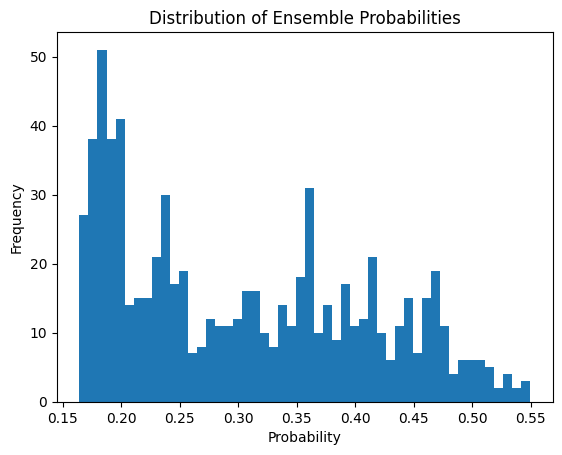

In [28]:
import numpy as np

print("Min probability:", ensemble_probs.min())
print("Max probability:", ensemble_probs.max())
print("Mean probability:", ensemble_probs.mean())

import matplotlib.pyplot as plt
plt.hist(ensemble_probs, bins=50)
plt.title("Distribution of Ensemble Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()


In [22]:
model_path = r"models\baseline_model\LSTM\best_model.h5"
model = load_model(model_path)

# Predict on the last test split
y_prob = model.predict(final_X_test).flatten()

test_start_index = len(df) - len(final_y_test)
test_prices = df['close'].values[test_start_index:]

report_file = backtest_with_report(test_prices, y_prob, threshold=0.25,
                                   stop_loss=0.05, take_profit=0.1,
                                   output_dir="backtest_results")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Backtest report saved to backtest_results\backtest_report.html
